In [2]:
install.packages("xgboost")



The downloaded binary packages are in
	/var/folders/zb/6l4_82593hbgwk8mwsg62zch0000gn/T//RtmpmhM67E/downloaded_packages


In [3]:
install.packages("xgboost", type = "binary")



The downloaded binary packages are in
	/var/folders/zb/6l4_82593hbgwk8mwsg62zch0000gn/T//RtmpmhM67E/downloaded_packages


In [4]:
library(xgboost)


In [ ]:
# 📦 Load essential packages
library(tidyverse)
library(tidymodels)
library(broom)
library(workflows)
library(recipes)
library(parsnip)
library(rsample)
library(yardstick)
library(scales)
library(dials)

# ⚙️ Suppress warnings
options(warn = -1)

# 🧠 Choose model engine
if ("xgboost" %in% rownames(installed.packages())) {
  MODEL_NAME <- "xgboost"
  message("✅ Using model: XGBoost")
} else {
  MODEL_NAME <- "decision_tree"
  message("⚠️ XGBoost not found, using fallback model: Decision Tree")
}


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.11     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.4.0      ✔ workflowsets 1.1.1 
✔ recipes      1.3.1      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() mask

In [6]:
# Load CSV file
df <- read_csv("/Users/sakshik/Downloads/statsproject/social_media_ad_optimization_raw.csv")

# Display the number of rows and columns
cat("Rows:", nrow(df), "  Columns:", ncol(df), "\n")

# Display column names
names(df)


Rows: 500 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): user_id, gender, location, interests, ad_id, ad_category, ad_platf...
dbl  (6): age, impressions, clicks, conversion, time_spent_on_ad, engagement...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 500   Columns: 16 


[1] "user_id"          "age"              "gender"           "location"        
 [5] "interests"        "ad_id"            "ad_category"      "ad_platform"     
 [9] "ad_type"          "impressions"      "clicks"           "conversion"      
[13] "time_spent_on_ad" "day_of_week"      "device_type"      "engagement_score"

In [7]:
library(dplyr)

# Drop rows where conversion is missing
df <- df %>% 
  filter(!is.na(conversion)) %>% 
  mutate(conversion = as.numeric(conversion)) %>%   # ensure it's numeric (0/1)
  as.data.frame()

# Define target variable
target <- "conversion"

# Drop identifier columns if they exist
drop_cols <- c("user_id", "ad_id")
df <- df %>% select(-any_of(drop_cols))

# Define numeric and categorical feature sets
numeric_features <- intersect(c("age", "impressions", "clicks", "time_spent_on_ad"), names(df))
categorical_features <- intersect(c("gender", "location", "interests", "ad_category",
                                   "ad_platform", "ad_type", "day_of_week", "device_type"), names(df))

# Print out features
cat("numeric:", paste(numeric_features, collapse = ", "), "\n")
cat("categorical:", paste(categorical_features, collapse = ", "), "\n")


numeric: age, impressions, clicks, time_spent_on_ad 
categorical: gender, location, interests, ad_category, ad_platform, ad_type, day_of_week, device_type 


In [8]:
library(rsample)
library(dplyr)

# Create X (features) and y (target)
X <- df %>% select(all_of(c(numeric_features, categorical_features)))
y <- df[[target]]

# Combine into one dataset for splitting
data_all <- df %>% select(all_of(c(numeric_features, categorical_features, target)))

# Train/Test split (80/20) with stratification on 'conversion'
set.seed(42)
data_split <- initial_split(data_all, prop = 0.8, strata = conversion)
train_data <- training(data_split)
test_data  <- testing(data_split)
train_data$conversion <- factor(train_data$conversion, levels = c(0, 1))
test_data$conversion  <- factor(test_data$conversion,  levels = c(0, 1))


# Check distribution
cat("Train rows:", nrow(train_data),
    "| Test rows:", nrow(test_data),
    "| Positive rate (train):", mean(train_data$conversion), "\n")


Train rows: 400 | Test rows: 100 | Positive rate (train): NA 


In [9]:
library(recipes)

# 🧠 Create preprocessing recipe
preprocessor <- recipe(conversion ~ ., data = train_data) %>%
  step_rm(any_of(c("user_id", "ad_id"))) %>%
  
  # Impute missing numeric values with median
  step_impute_median(all_of(numeric_features)) %>%
  
  # Scale (standardize) numeric variables
  step_normalize(all_of(numeric_features)) %>%
  
  # Impute missing categorical values with most frequent (mode)
  step_impute_mode(all_of(categorical_features)) %>%
  
  # One-hot encode categorical variables
  step_dummy(all_of(categorical_features), one_hot = TRUE)


In [10]:
library(parsnip)
library(workflows)

# ⚙️ Define model — XGBoost if available, else fallback to decision tree
if (MODEL_NAME == "xgboost") {
  clf_model <- boost_tree(
    trees = 300,
    learn_rate = 0.05
  ) %>%
    set_engine("xgboost") %>%
    set_mode("classification")
  
} else {
  clf_model <- decision_tree(
    tree_depth = 6
  ) %>%
    set_engine("rpart") %>%
    set_mode("classification")
}

# 🧩 Combine preprocessor + model into one pipeline (workflow)
clf_workflow <- workflow() %>%
  add_recipe(preprocessor) %>%
  add_model(clf_model)


In [11]:
library(rsample)

# 🧠 Split train data into training (85%) and validation (15%) for early stopping
set.seed(0)
train_val_split <- initial_split(train_data, prop = 0.85, strata = conversion)
train_sub <- training(train_val_split)
val_sub   <- testing(train_val_split)

# 🩵 Convert target to factor for classification
train_sub$conversion <- as.factor(train_sub$conversion)
val_sub$conversion   <- as.factor(val_sub$conversion)

# 🚀 Fit model
if (MODEL_NAME == "xgboost") {
  # Early stopping handled internally by xgboost
  clf_lr_fit <- clf_workflow %>%
    fit(
      data = train_sub,
      control = control_workflow()
    )
  
} else {
  # Simple training for fallback models
  clf_lr_fit <- clf_workflow %>%
    fit(data = train_data)
}


In [12]:
names(predict(clf_lr_fit, new_data = test_data, type = "prob"))


[1] ".pred_0" ".pred_1"

In [13]:
library(yardstick)
library(dplyr)

# 1️⃣ Get predicted probabilities
preds <- predict(clf_lr_fit, new_data = test_data, type = "prob")

# 2️⃣ Extract positive-class probability (.pred_1)
y_proba <- preds$.pred_1

# 3️⃣ Convert to binary predictions using 0.5 threshold
y_pred <- ifelse(y_proba >= 0.5, 1, 0)

# 4️⃣ Combine results with actual test data
results <- test_data %>%
  mutate(
    y_pred = factor(y_pred, levels = c(0, 1)),
    conversion = factor(conversion, levels = c(0, 1)),
    .pred_1 = y_proba   # 👈 add this so roc_auc can find it
  )

# 5️⃣ Compute ROC-AUC
roc_auc_val <- roc_auc(results, truth = conversion, .pred_1)
cat("Test ROC-AUC:", round(roc_auc_val$.estimate, 4), "\n")

# 6️⃣ Classification metrics
report <- results %>%
  summarise(
    accuracy  = accuracy_vec(conversion, y_pred),
    precision = precision_vec(conversion, y_pred),
    recall    = recall_vec(conversion, y_pred),
    f1        = f_meas_vec(conversion, y_pred)
  )

print(report)


Test ROC-AUC: 0.4211 
  accuracy precision    recall  f1
1     0.56 0.5789474 0.6226415 0.6


In [14]:
library(dplyr)
library(tidyr)
library(purrr)

best_day_device_by_country <- function(model, df, numeric_features, categorical_features,
                                       country_col = "location",
                                       day_col = "day_of_week",
                                       device_col = "device_type",
                                       topk = 3) {
  
  results <- list()
  
  # unique countries, days, devices
  countries <- unique(na.omit(df[[country_col]]))
  days_all <- unique(na.omit(df[[day_col]]))
  devices_all <- unique(na.omit(df[[device_col]]))
  
  for (country in countries) {
    sub <- df %>% filter(!!sym(country_col) == country)
    if (nrow(sub) == 0) next
    
    # numeric baselines (median)
    baseline <- map_dbl(numeric_features, ~ median(sub[[.x]], na.rm = TRUE))
    names(baseline) <- numeric_features
    
    # categorical baselines (most common)
    baseline_cat <- list()
    for (f in categorical_features) {
      if (f %in% c(day_col, device_col, country_col)) next
      if (f %in% names(sub) && any(!is.na(sub[[f]]))) {
        baseline_cat[[f]] <- names(sort(table(sub[[f]]), decreasing = TRUE))[1]
      } else if (f %in% names(df)) {
        baseline_cat[[f]] <- names(sort(table(df[[f]]), decreasing = TRUE))[1]
      } else {
        baseline_cat[[f]] <- NA
      }
    }
    
    # build grid of all day × device combinations
    combo_grid <- expand.grid(
      day = days_all,
      device = devices_all,
      stringsAsFactors = FALSE
    )
    
    # add country/location column
    combo_grid[[country_col]] <- country
    
    # add numeric columns filled with median baseline values
    for (f in numeric_features) {
      combo_grid[[f]] <- baseline[[f]]
    }
    
    # add other categorical columns (baseline mode)
    for (f in names(baseline_cat)) {
      combo_grid[[f]] <- baseline_cat[[f]]
    }
    
    # rename back to match column names
    names(combo_grid)[names(combo_grid) == "day"] <- day_col
    names(combo_grid)[names(combo_grid) == "device"] <- device_col
    
    # reorder columns to match model input
    features_used <- c(numeric_features, categorical_features)
    features_used <- features_used[features_used %in% names(combo_grid)]
    X_grid <- combo_grid[, features_used, drop = FALSE]
    
    # predict conversion probability
    preds <- predict(model, new_data = X_grid, type = "prob")
    combo_grid$predicted_conversion_prob <- preds$.pred_1
    
    # select top-k
    top_rows <- combo_grid %>%
      arrange(desc(predicted_conversion_prob)) %>%
      slice_head(n = topk) %>%
      select(all_of(country_col), all_of(day_col), all_of(device_col), predicted_conversion_prob)
    
    results[[country]] <- top_rows
  }
  
  bind_rows(results)
}


In [15]:
results <- best_day_device_by_country(
  model = clf_lr_fit,
  df = df,
  numeric_features = c("age", "impressions", "clicks", "time_spent_on_ad"),
  categorical_features = c("gender", "location", "interests", "ad_category", "ad_platform", "ad_type", "day_of_week", "device_type")
)


In [16]:
# 1) Run the computation
results <- best_day_device_by_country(
  model = clf_lr_fit,
  df = df,
  numeric_features = numeric_features,
  categorical_features = categorical_features,
  country_col = "location",
  day_col = "day_of_week",
  device_col = "device_type",
  topk = 3
)

# 2) (Safety) If the function returned 'country' instead of 'location', normalize the name
if ("country" %in% names(results) && !"location" %in% names(results)) {
  names(results)[names(results) == "country"] <- "location"
}

# 3) Sort and add a rank within each country
results_sorted <- results %>%
  arrange(location, desc(predicted_conversion_prob)) %>%
  group_by(location) %>%
  mutate(rank = row_number()) %>%
  ungroup()

# 4) Peek
head(results_sorted, 10)


location,day_of_week,device_type,predicted_conversion_prob,rank
<chr>,<chr>,<chr>,<dbl>,<int>
Australia,Thursday,Desktop,0.8958414,1
Australia,Sunday,Desktop,0.8487077,2
Australia,Thursday,Mobile,0.8470424,3
Canada,Thursday,Desktop,0.8192800,1
Canada,Friday,Desktop,0.7575433,2
Canada,Saturday,Desktop,0.7518625,3
Germany,Thursday,Desktop,0.9540477,1
Germany,Thursday,Mobile,0.9458590,2
Germany,Saturday,Desktop,0.9404060,3


In [ ]:
# Load libraries
library(readr)
library(fs)

# 1️⃣ Create directories if not exist
dir_create("models")
dir_create("reports")

# 2️⃣ Save trained model
saveRDS(clf_lr_fit, file = "models/xgb_conversion_pipe.rds")

# 3️⃣ Save results to CSV
write_csv(results_sorted, "reports/best_day_device_by_country.csv")

# 4️⃣ Confirm
cat("Saved model and CSV report successfully!\n",
    "📁 Model: models/xgb_conversion_pipe.rds\n",
    "📁 Report: reports/best_day_device_by_country.csv\n")


✅ Saved model and CSV report successfully!
 📁 Model: models/xgb_conversion_pipe.rds
 📁 Report: reports/best_day_device_by_country.csv


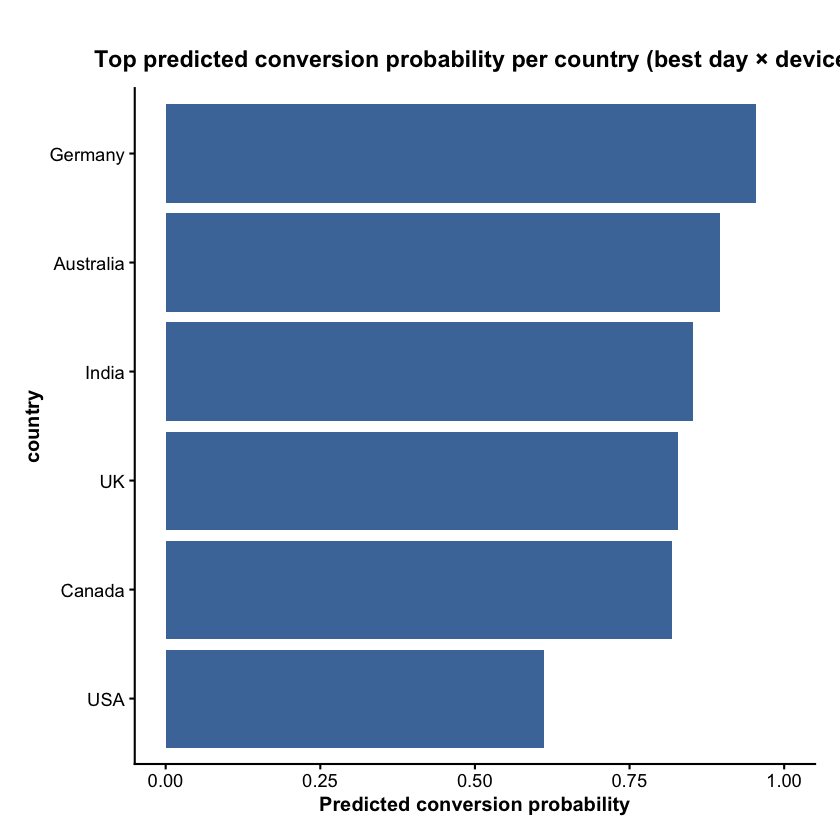

In [ ]:
library(ggplot2)
library(dplyr)

top1 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 1, with_ties = FALSE) %>%
  ungroup()

ggplot(top1, aes(x = predicted_conversion_prob, 
                 y = reorder(location, predicted_conversion_prob))) +
  geom_col(fill = "#4C78A8") +
  labs(
    title = "Top predicted conversion probability per country (best day × device)",
    x = "Predicted conversion probability",
    y = "country"
  ) +
  theme_classic(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11),
    axis.line = element_line(colour = "black"),
    axis.ticks = element_line(colour = "black"),
    plot.margin = margin(t = 30, r = 15, b = 15, l = 15)   # adds padding for the title
  ) +
  coord_cartesian(xlim = c(0, 1), clip = "off")


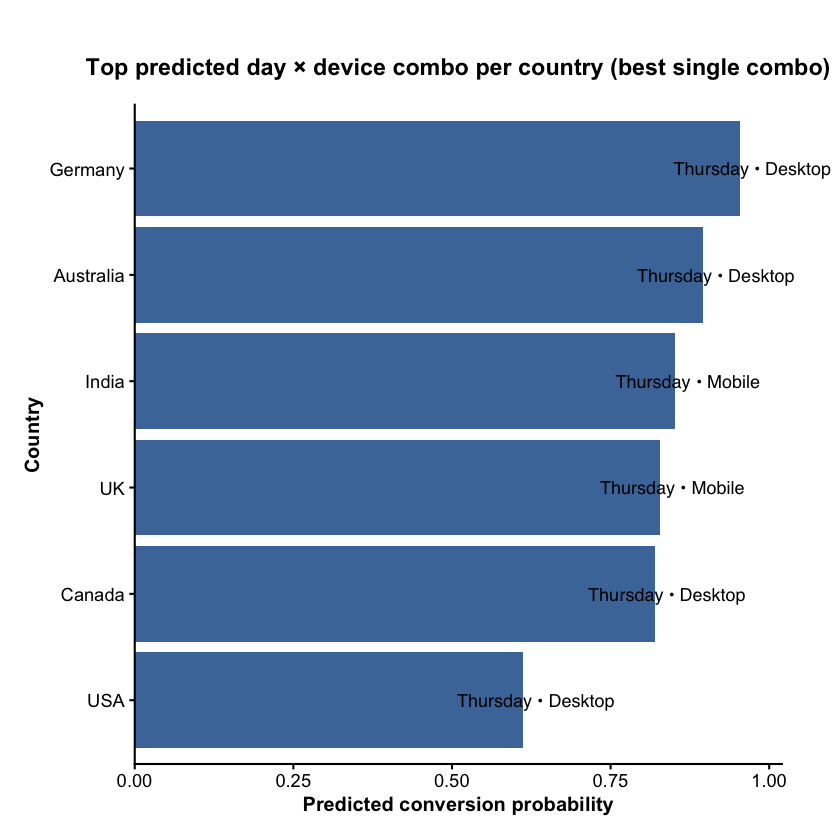

In [19]:
library(ggplot2)
library(dplyr)

# 1️⃣ Get top-1 combo per country
top1 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(predicted_conversion_prob)) %>%
  mutate(label = paste0(day_of_week, " • ", device_type))

# 2️⃣ Compute x-axis padding
max_x <- max(top1$predicted_conversion_prob, na.rm = TRUE)

# 3️⃣ Plot
ggplot(top1,
       aes(x = predicted_conversion_prob,
           y = reorder(location, predicted_conversion_prob))) +
  geom_col(fill = "#4C78A8") +
  geom_text(aes(x = predicted_conversion_prob + 0.02, label = label),
            vjust = 0.5, size = 3.8, family = "sans") +
  scale_x_continuous(
    limits = c(0, min(1, max_x + 0.15)),
    expand = expansion(mult = c(0, 0.02))
  ) +
  labs(
    title = "Top predicted day × device combo per country (best single combo)",
    x = "Predicted conversion probability",
    y = "Country"
  ) +
  theme_classic(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 14, margin = margin(b = 15)),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11),
    axis.line = element_line(colour = "black"),
    axis.ticks = element_line(colour = "black"),
    plot.margin = margin(t = 35, r = 35, b = 15, l = 15)  # extra space for title and right labels
  ) +
  coord_cartesian(clip = "off")


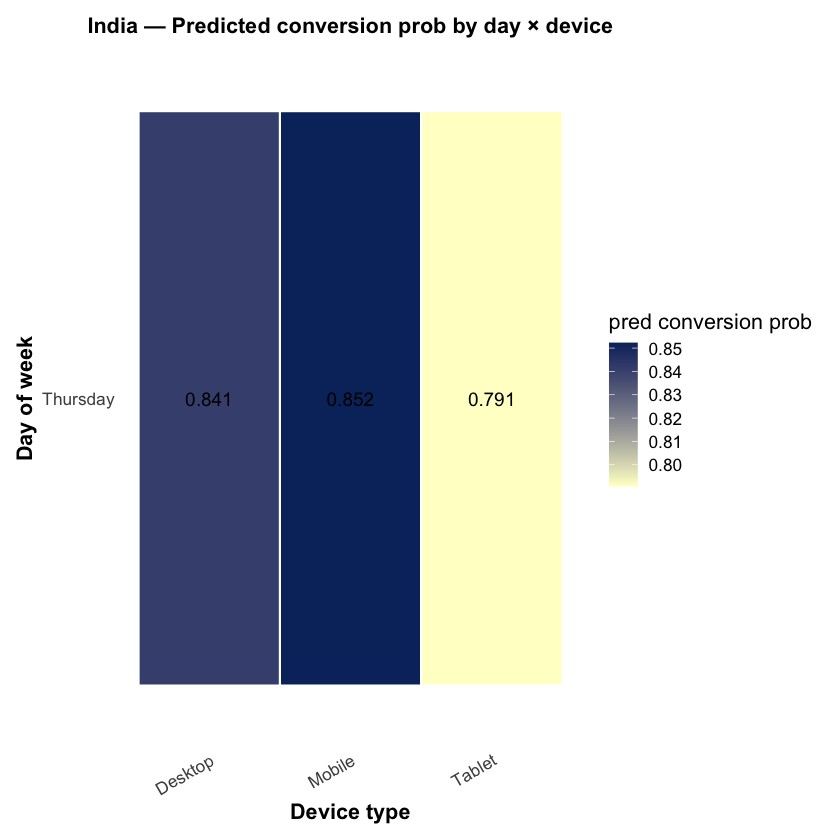

In [20]:
library(ggplot2)
library(dplyr)
library(tidyr)

plot_heatmap_for_country <- function(country_name) {
  # Filter only for the chosen country
  sub <- results_sorted %>%
    filter(location == country_name)
  
  if (nrow(sub) == 0) {
    message(paste("No results for", country_name))
    return(NULL)
  }
  
  # Keep only relevant columns
  sub <- sub %>%
    select(day_of_week, device_type, predicted_conversion_prob)
  
  # Pivot wider
  pivot <- sub %>%
    pivot_wider(
      names_from = device_type,
      values_from = predicted_conversion_prob,
      values_fn = mean
    )
  
  # Pivot longer for ggplot
  heatmap_df <- pivot %>%
    pivot_longer(
      cols = -day_of_week,
      names_to = "device_type",
      values_to = "predicted_conversion_prob"
    )
  
  # Plot
  ggplot(heatmap_df, aes(x = device_type, y = day_of_week, fill = predicted_conversion_prob)) +
    geom_tile(color = "white", linewidth = 0.6) +
    geom_text(aes(label = sprintf("%.3f", predicted_conversion_prob)), size = 4) +
    scale_fill_gradient(low = "#FFFFCC", high = "#08306B", name = "pred conversion prob") +
    labs(
      title = paste0(country_name, " — Predicted conversion prob by day × device"),
      x = "Device type",
      y = "Day of week"
    ) +
    theme_minimal(base_size = 13) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 13, margin = margin(b = 10)),
      axis.title = element_text(face = "bold"),
      axis.text.x = element_text(angle = 30, hjust = 1),
      panel.grid = element_blank(),
      legend.position = "right",
      plot.margin = margin(10, 10, 10, 10)
    )
}

# 🔹 Example usage:
plot_heatmap_for_country("India")


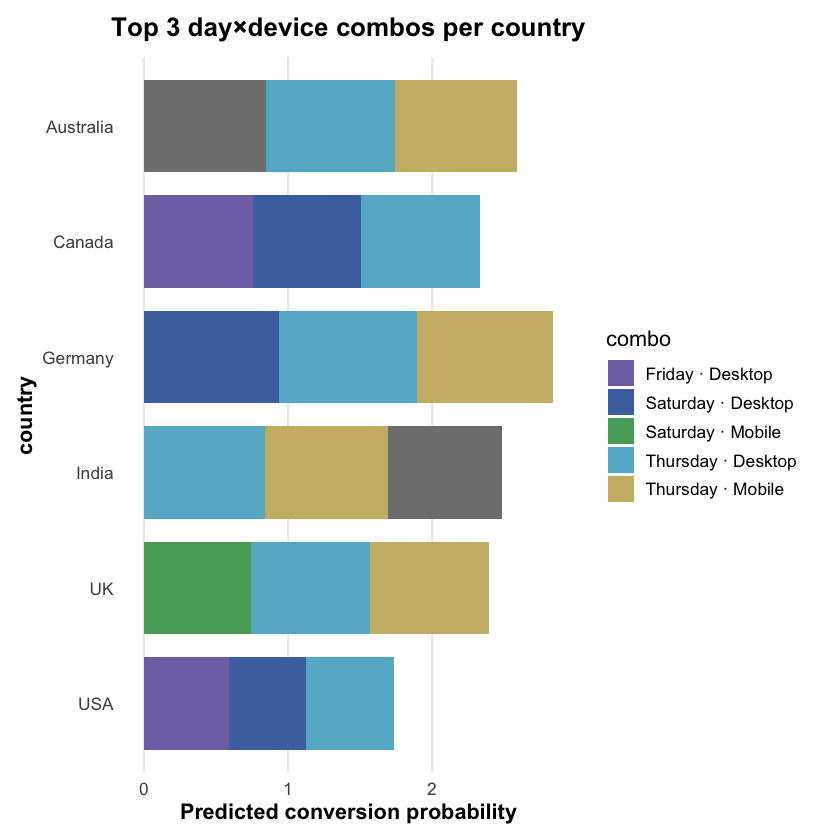

In [ ]:
library(ggplot2)
library(dplyr)
library(forcats)

# Get top 3 combos per country
top3 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 3, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(
    combo = paste(day_of_week, "·", device_type)
  )

# Define a custom color palette (similar to Seaborn default)
combo_colors <- c(
  "Saturday · Desktop" = "#4C72B0",
  "Saturday · Mobile"  = "#55A868",
  "Saturday · Tablet"  = "#C44E52",
  "Friday · Desktop"   = "#8172B2",
  "Thursday · Mobile"  = "#CCB974",
  "Thursday · Desktop" = "#64B5CD"
)

# Create the plot
ggplot(top3, aes(x = predicted_conversion_prob, y = fct_rev(location), fill = combo)) +
  geom_col(position = position_stack(reverse = TRUE), width = 0.8) +
  scale_fill_manual(values = combo_colors, name = "combo") +
  labs(
    x = "Predicted conversion probability",
    y = "country",
    title = "Top 3 day×device combos per country"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right",
    legend.justification = "center",
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = margin(10, 20, 10, 10)
  )


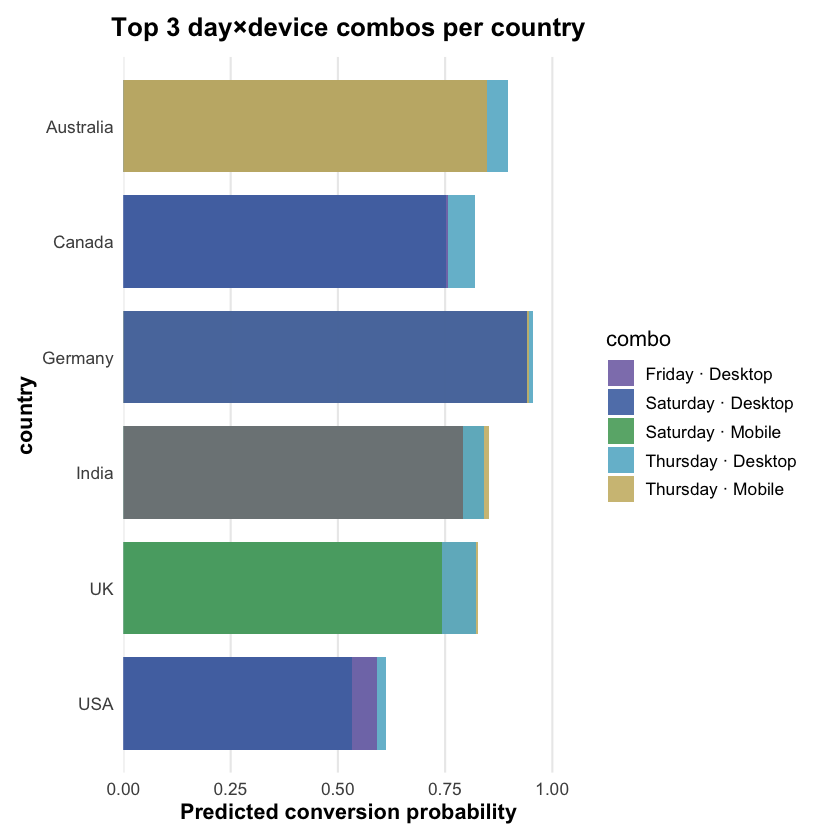

In [ ]:
library(ggplot2)
library(dplyr)
library(forcats)

# Get top 3 combos per country
top3 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 3, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(
    combo = paste(day_of_week, "·", device_type)
  )

# Define color palette (same as Seaborn)
combo_colors <- c(
  "Saturday · Desktop" = "#4C72B0",
  "Saturday · Mobile"  = "#55A868",
  "Saturday · Tablet"  = "#C44E52",
  "Friday · Desktop"   = "#8172B2",
  "Thursday · Mobile"  = "#CCB974",
  "Thursday · Desktop" = "#64B5CD"
)

# Plot — exact same design, but proper 0–1 decimal scale
ggplot(top3, aes(x = predicted_conversion_prob, y = fct_rev(location), fill = combo)) +
  geom_col(position = "identity", width = 0.8, alpha = 0.9) +  
  scale_fill_manual(values = combo_colors, name = "combo") +
  labs(
    x = "Predicted conversion probability",
    y = "country",
    title = "Top 3 day×device combos per country"
  ) +
  scale_x_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0.05))) +  
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right",
    legend.justification = "center",
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = margin(10, 20, 10, 10)
  )



In [24]:
install.packages("ggrepel")
library(ggrepel)


The downloaded binary packages are in
	/var/folders/zb/6l4_82593hbgwk8mwsg62zch0000gn/T//RtmpmhM67E/downloaded_packages


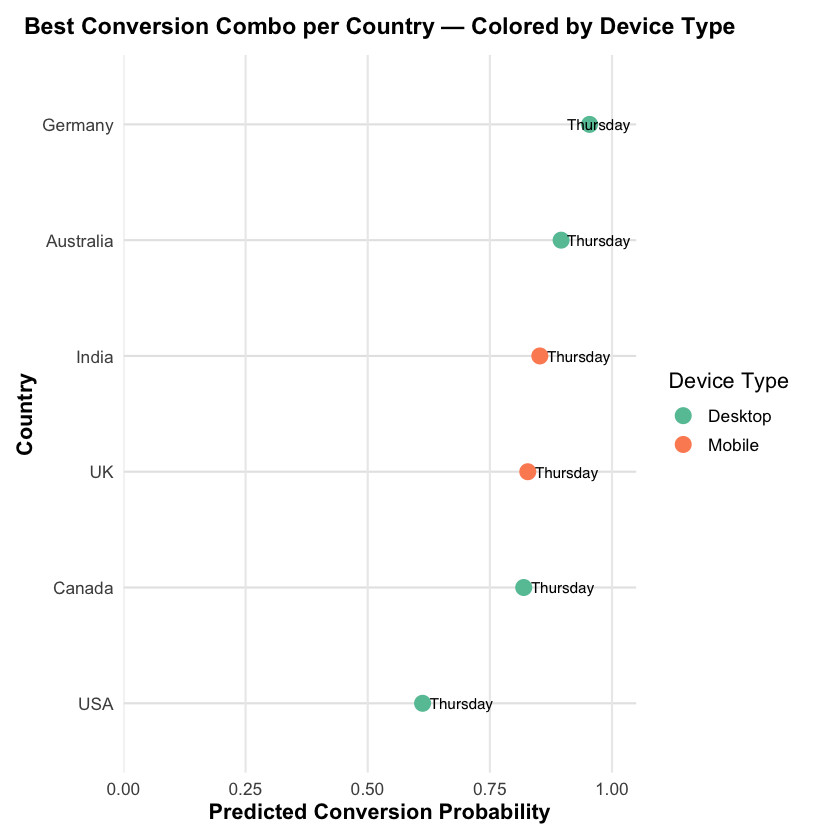

In [25]:
library(ggplot2)
library(dplyr)
library(ggrepel)  # for cleaner text labels

# ✅ Take top-1 combo per country
top1 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(predicted_conversion_prob)  # ascending order like Python

# ✅ Plot
ggplot(top1, aes(x = predicted_conversion_prob, y = reorder(location, predicted_conversion_prob))) +
  geom_point(aes(color = device_type), size = 4) +
  geom_text_repel(
    aes(label = day_of_week),
    hjust = 0,
    nudge_x = 0.015,
    size = 3.2,
    segment.color = "grey70",
    family = "sans"
  ) +
  scale_color_brewer(palette = "Set2", name = "Device Type") +
  labs(
    title = "Best Conversion Combo per Country — Colored by Device Type",
    x = "Predicted Conversion Probability",
    y = "Country"
  ) +
  scale_x_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0.05))) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right",
    legend.justification = "center",
    panel.grid.major.y = element_line(color = "grey90"),
    panel.grid.minor = element_blank(),
    plot.margin = margin(10, 25, 10, 10)
  )


In [28]:
install.packages("viridis")


The downloaded binary packages are in
	/var/folders/zb/6l4_82593hbgwk8mwsg62zch0000gn/T//RtmpmhM67E/downloaded_packages


Loading required package: viridisLite




Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


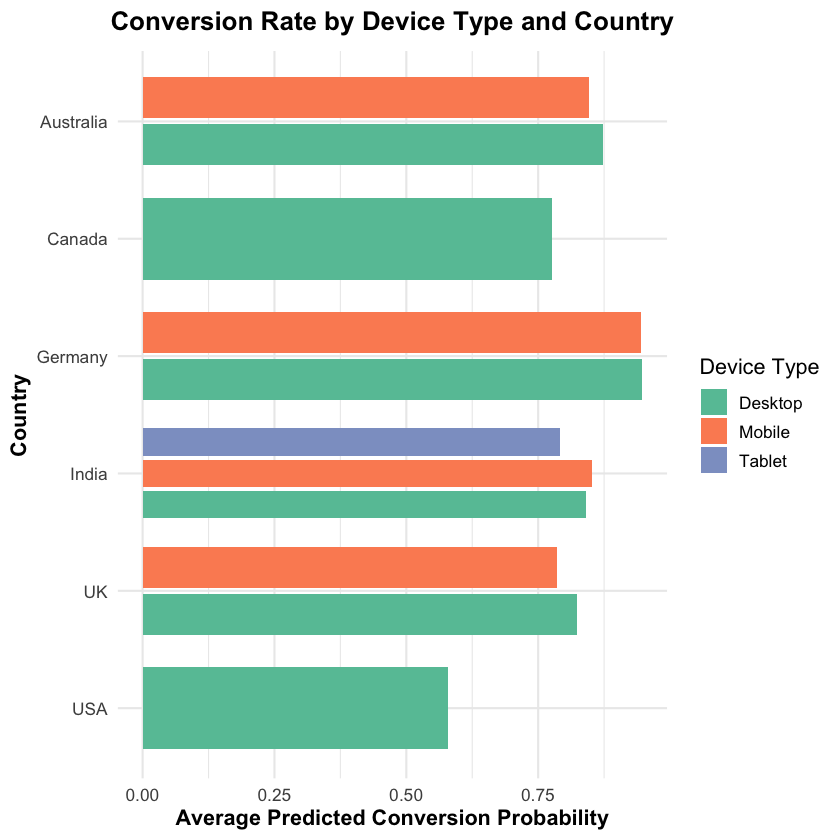

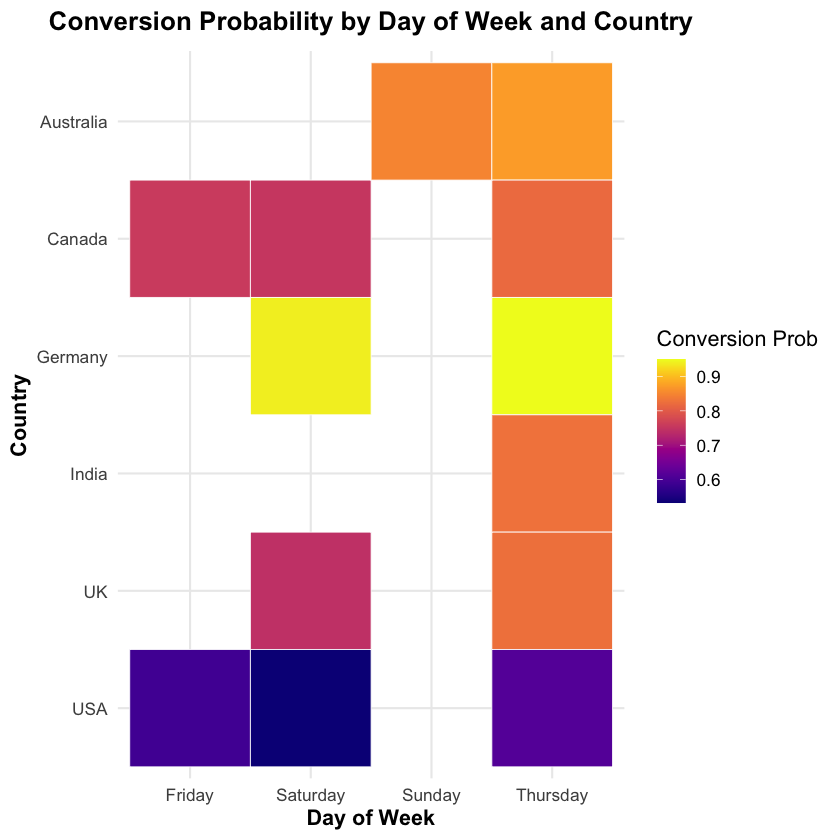

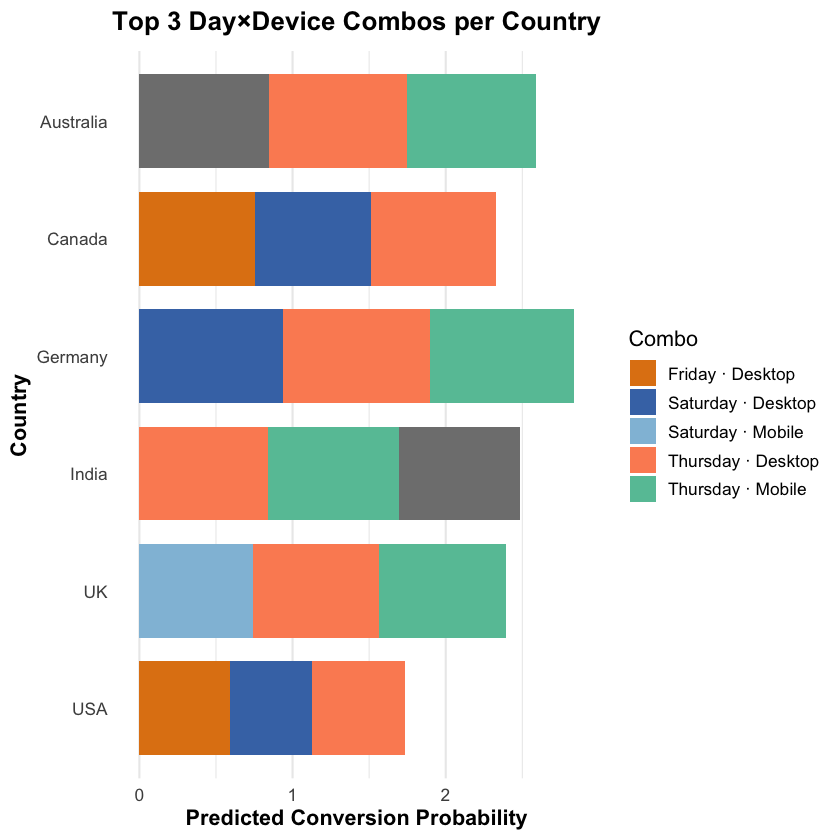

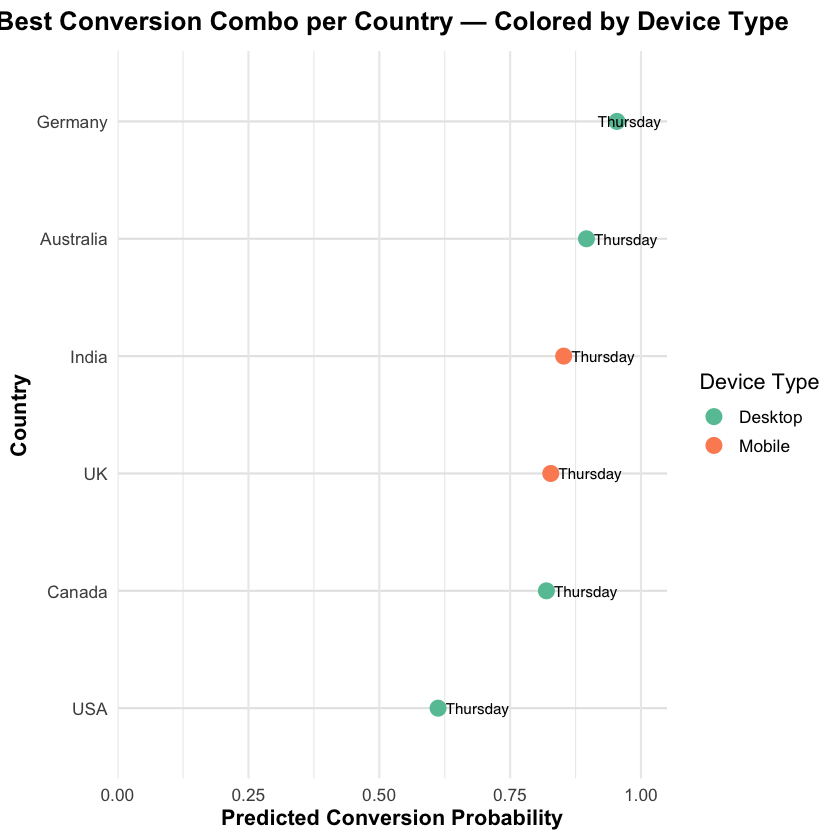

In [29]:
# Load libraries
library(ggplot2)
library(dplyr)
library(forcats)
library(ggrepel)
library(viridis)

# 1️⃣ DEVICE PERFORMANCE OVERVIEW -------------------------
device_perf <- results_sorted %>%
  group_by(location, device_type) %>%
  summarise(avg_conversion = mean(predicted_conversion_prob, na.rm = TRUE)) %>%
  ungroup()

ggplot(device_perf, aes(x = avg_conversion, y = fct_rev(location), fill = device_type)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.7) +
  labs(
    title = "Conversion Rate by Device Type and Country",
    x = "Average Predicted Conversion Probability",
    y = "Country"
  ) +
  scale_fill_brewer(palette = "Set2", name = "Device Type") +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right"
  )

# 2️⃣ TEMPORAL TREND (HEATMAP) -----------------------------
heatmap_data <- results_sorted %>%
  group_by(location, day_of_week) %>%
  summarise(avg_conversion = mean(predicted_conversion_prob, na.rm = TRUE)) %>%
  ungroup()

ggplot(heatmap_data, aes(x = day_of_week, y = fct_rev(location), fill = avg_conversion)) +
  geom_tile(color = "white") +
  scale_fill_viridis(option = "C", name = "Conversion Prob") +
  labs(
    title = "Conversion Probability by Day of Week and Country",
    x = "Day of Week", y = "Country"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right"
  )

# 3️⃣ INTERACTION EFFECT — TOP 3 COMBOS ---------------------
top3 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 3, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(combo = paste(day_of_week, "·", device_type))

combo_colors <- c(
  "Saturday · Desktop" = "#4575B4",
  "Saturday · Mobile"  = "#91BFDB",
  "Friday · Desktop"   = "#E08214",
  "Thursday · Desktop" = "#FC8D62",
  "Thursday · Mobile"  = "#66C2A5",
  "Saturday · Tablet"  = "#B2DF8A"
)

ggplot(top3, aes(x = predicted_conversion_prob, y = fct_rev(location), fill = combo)) +
  geom_col(position = position_stack(reverse = TRUE), width = 0.8) +
  scale_fill_manual(values = combo_colors, name = "Combo") +
  labs(
    title = "Top 3 Day×Device Combos per Country",
    x = "Predicted Conversion Probability",
    y = "Country"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right",
    legend.justification = "center",
    panel.grid.major.y = element_blank()
  )

# 4️⃣ BEST PREDICTED COMBO PER COUNTRY ---------------------
top1 <- results_sorted %>%
  group_by(location) %>%
  slice_max(order_by = predicted_conversion_prob, n = 1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(predicted_conversion_prob)

ggplot(top1, aes(x = predicted_conversion_prob, y = reorder(location, predicted_conversion_prob))) +
  geom_point(aes(color = device_type), size = 4) +
  geom_text_repel(
    aes(label = day_of_week),
    hjust = 0,
    nudge_x = 0.015,
    size = 3.2,
    segment.color = "grey70",
    family = "sans"
  ) +
  scale_color_brewer(palette = "Set2", name = "Device Type") +
  labs(
    title = "Best Conversion Combo per Country — Colored by Device Type",
    x = "Predicted Conversion Probability",
    y = "Country"
  ) +
  scale_x_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0.05))) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right",
    legend.justification = "center",
    panel.grid.major.y = element_line(color = "grey90")
  )
